## Fit and analyze decoder models
The next step of the BehaveNet pipeline is using simultaneously recorded neural activity to predict behavior. Specifically, we can predict either of our compressed descriptions of behavior: the convolutional autoencoder latents or the ARHMM states.

We use linear models or feedforward deep networks to predict the state or latents for a given frame given a window of neural activity. We then compare our predictions to baseline (aka chance) performance. We can also use the convolutional autoencoder to convert the predicted latents into a full predicted behavioral video and compare to the original behavior.


<br>

### Contents
* [Decoding discrete states](#Decoding-discrete-states)
* [Decoding continuous latents](#Decoding-continuous-latents)
* [Assess decoding performance](#Assess-decoding-performance)
* [Plot true vs predicted latents](#Plot-true-vs-predicted-latents)
* [Make real vs predicted movies](#Make-real-vs-predicted-movies)


In [1]:
import time
import pickle
import scipy
import scipy.io as sio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

matplotlib.rcParams.update({'font.size': 18, 'figure.figsize': (16, 8)})
from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.data.utils import get_transforms_paths
from behavenet.data.utils import load_labels_like_latents
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example
from behavenet.plotting.arhmm_utils import *

from behavenet.fitting.utils import get_best_model_and_data
from behavenet.fitting.eval import export_predictions
from behavenet.models import Decoder

save_outputs = True  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4

from sklearn.metrics import r2_score

In [2]:
from behavenet.fitting.utils import get_subdirs
import os
          
def latent_results(expt_name=None, sess_id="", version='best'):
    # set model info
    sess_idx = 0
    hparams = {
        'data_dir': get_user_dir('data'),
        'save_dir': get_user_dir('save'),
        'model_class': 'neural-ae',
        'ae_model_type': 'conv',
        'ae_experiment_name': 'latent_search',
        'n_ae_latents': 9,
        'experiment_name':'grid_search',
        'model_type':'ff',
        'n_max_lags': 8,
        'rng_seed_data': 0,
        'trial_splits': '8;1;1;0'
    }

    hparams['neural_ae_experiment_name'] = hparams['experiment_name']
    hparams['neural_ae_model_type'] = hparams['model_type']
    hparams['neural_ae_version'] = version
    
    get_lab_example(hparams, 'dipoppa', sess_id)
    
    hparams['session_dir'], sess_ids = get_session_dir(hparams)
    expt_dir = get_expt_dir(hparams)

    ## Get discrete chance performance (accuracy of always predicting the most common training state)
    _, latents_file = get_transforms_paths('ae_latents', hparams, sess_ids[sess_idx])
    with open(latents_file, 'rb') as f:
        all_latents = pickle.load(f)
    mean_ae_latents = np.mean(np.concatenate([all_latents['latents'][i] for i in all_latents['trials']['train']]),axis=0)

    all_test_latents = np.concatenate([all_latents['latents'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    chance_ae_performance = np.mean((all_test_latents-mean_ae_latents)**2)
    
    ## Get discrete prediction performance
    # If sub-sampling - make sure to get results labelled by sample method and index name 
    if expt_name is not None:
        hparams['subsample_method'] = 'single'
        hparams['subsample_idxs_name'] = expt_name
        
    
    _, latent_predictions_file = get_transforms_paths('neural_ae_predictions', hparams, sess_ids[sess_idx])

    
    if not os.path.exists(latent_predictions_file):
        model, data_generator = get_best_model_and_data(hparams, Decoder, load_data=True, version=version)
        predictions = export_predictions(data_generator, model)
        
    with open(latent_predictions_file, 'rb') as f:
        all_latent_predictions = pickle.load(f)
    all_test_latent_predictions = np.concatenate([all_latent_predictions['predictions'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    decoding_ae_performance = np.mean((all_test_latents-all_test_latent_predictions)**2)
    r2 = r2_score(all_test_latents, all_test_latent_predictions)
    
    return (chance_ae_performance, decoding_ae_performance, r2)


# Decoding across cell types

In [7]:
# Inhibitory Decoding Performance (SST Neurons):
sst_mse = 0
for i in range(10):
    expt_name = 'sst85_sample_' + str(i)
    chance_performance, inh_decoding_performance = latent_results(expt_name=expt_name)
    sst_mse += inh_decoding_performance
    
# inh_decoding_performance = rsquared(inh_decoding_performance, chance_performance)

#Excitatory Decoding Performance:
sample_sizes = range(10)
exc_decoding_errors = []
for size in sample_sizes:
    chance_performance, decoding_performance = latent_results(expt_name='exc85_sample_{}'.format(size))
    exc_decoding_errors.append(decoding_performance)
    

In [12]:
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'model_class': 'neural-ae',
    'ae_model_type': 'conv',
    'ae_experiment_name': 'latent_search',
    'n_ae_latents': 9,
    'experiment_name':'grid_search',
    'model_type':'ff',
    'n_max_lags': 8,
    'rng_seed_data': 0,
    'trial_splits': '8;1;1;0'
}

hparams['neural_ae_experiment_name'] = hparams['experiment_name']
hparams['neural_ae_model_type'] = hparams['model_type']
hparams['subsample_method'] = 'single'
hparams['subsample_idxs_name'] = 'sst85_sample_1'

get_lab_example(hparams, 'dipoppa', 'session_1')

hparams['session_dir'], sess_ids = get_session_dir(hparams)
model, data_generator = get_best_model_and_data(hparams, Decoder, load_data=True, version='best')
predictions = export_predictions(data_generator, model)

Loading model defined in /home/samsung_2tb_ssd/yoni/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/sst85_sample_1-single/grid_search/version_0/meta_tags.pkl
saving predictions 1 of 1 to /home/samsung_2tb_ssd/yoni/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/sst85_sample_1-single/grid_search/version_0/dipoppa_full_trial_MD0ST5_1_predictions.pkl


# Decoding by number of neurons

In [35]:
sample_sizes = [20, 40, 60, 80, 100, 200, 300, 400, 600, 700, 800, 900, 1200, 1300]
decoding_errors_dict = {}
for i, SESS_ID in enumerate(['full_trial']):
    decoding_errors_dict[i] = {}
    for _, size in enumerate(sample_sizes):
        decoding_errors_dict[i][size] = []
        for t in range(10):
            expt_name='n{}_t{}'.format(size, t)
            chance_performance, decoding_mse, decoding_r2,  = latent_results(expt_name=expt_name, 
                                                                             sess_id=SESS_ID, 
                                                                             version='best')
            decoding_errors_dict[i][size].append(decoding_mse / chance_performance)

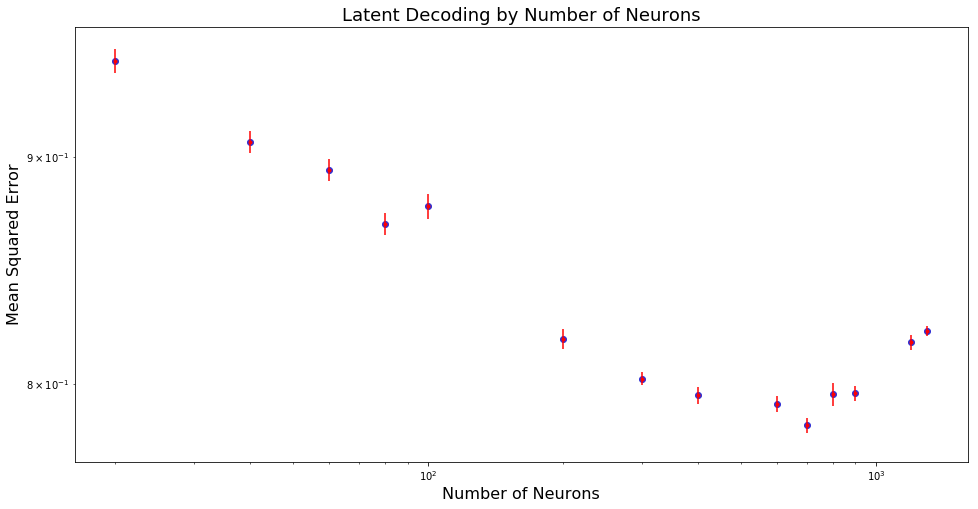

In [36]:
fig = plt.figure(figsize=(16,8))
std_errors = [scipy.stats.sem(decoding_errors_dict[0][x]) for x in sample_sizes]
mean_errors = [np.mean(decoding_errors_dict[0][x]) for x in sample_sizes]

plt.scatter(sample_sizes, mean_errors, color='#3030D3')
plt.errorbar(sample_sizes, mean_errors, yerr=std_errors, color='#FF0000', fmt='.')
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Mean Squared Error', fontsize=16)
plt.xlabel('Number of Neurons', fontsize=16)
plt.title('Latent Decoding by Number of Neurons', fontsize=18)
plt.show()